# Ground Projection

In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rc("figure", dpi=200)

from dt_computer_vision.camera import CameraModel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.ground_projection.rendering import debug_image
from dt_computer_vision_tests.line_detection_tests.test_detection import detect_color
from dt_computer_vision.ground_projection import GroundProjector

from dt_computer_vision.ground_projection.types import GroundPoint
from dt_computer_vision.camera import Pixel, NormalizedImagePoint

In [2]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image0.jpg")
image_orig: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]],
    # NOTE: this homography is computed in the 20-entrinsics-calibration jupyter notebook
    "H": [[-2.42749970e-02, 9.46389079e-02, 3.81909422e-01],
          [-4.55028567e-01, -1.17673909e-03, -1.87813039e-02],
          [-1.46006785e-01, 3.29784838e+00, 1]]
}

assert image_orig.shape == (480, 640, 3)

In [3]:
# create camera
camera = CameraModel(**camera_properties)
projector = GroundProjector(camera)

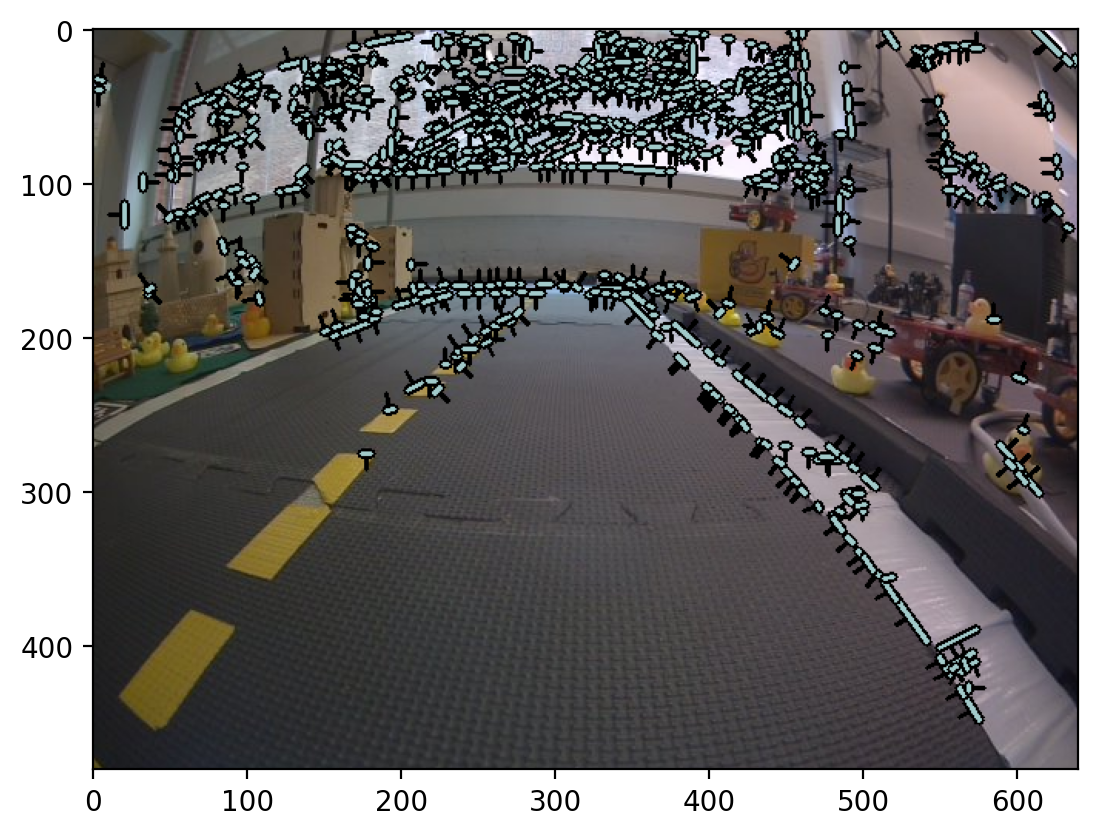

In [4]:
# detect segments
color: str = "white"
segments, image_w_detections = detect_color(image_orig, color)

# draw segments
image_w_detections = cv2.cvtColor(image_w_detections, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_detections)

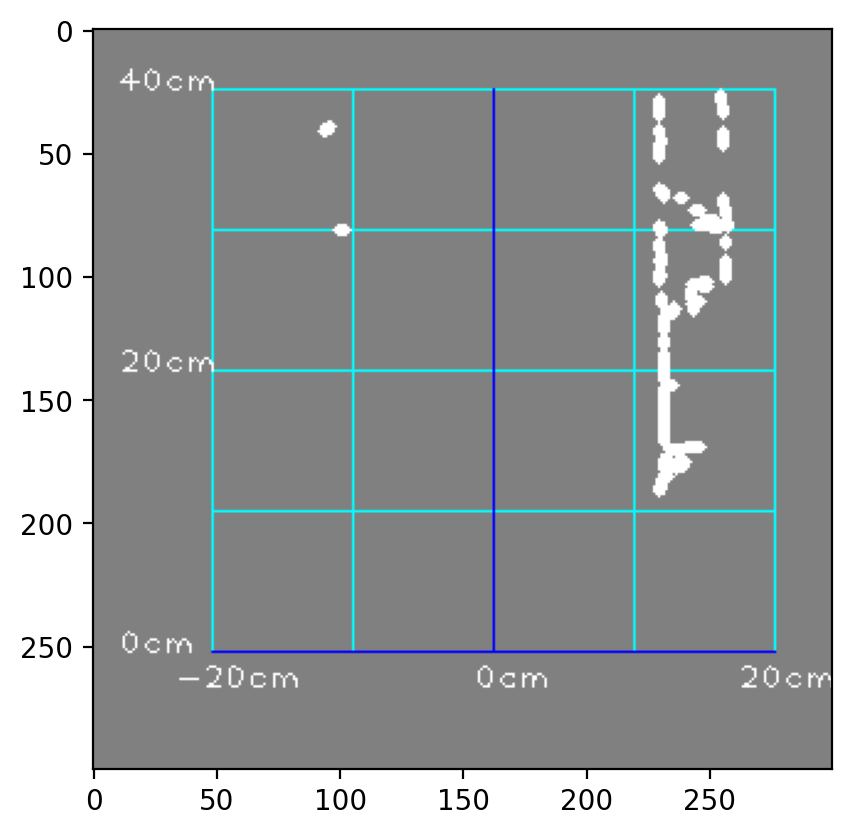

In [5]:
# project segments onto the ground plane
colored_segments = {
    (255, 255, 255): []
}

for segment in segments.lines:
    # distorted pixels
    p0: Pixel = Pixel(segment[0], segment[1])
    p1: Pixel = Pixel(segment[2], segment[3])
    #print(p0)
    # distorted pixels to rectified pixels
    p0_rect: Pixel = camera.rectifier.rectify_pixel(p0)
    p1_rect: Pixel = camera.rectifier.rectify_pixel(p1)
    #print(p0_rect)
    # rectified pixel to normalized coordinates
    p0_norm: NormalizedImagePoint = camera.pixel2vector(p0_rect)
    p1_norm: NormalizedImagePoint = camera.pixel2vector(p1_rect)
    #print(p0_norm)
    # project image point onto the ground plane
    p0_ground: GroundPoint = projector.vector2ground(p0_norm)
    p1_ground: GroundPoint = projector.vector2ground(p1_norm)
    # print(p0)
    # add grounded segment to output
    colored_segments[(255, 255, 255)].append((p0_ground, p1_ground))

image_w_projected_segments = debug_image(colored_segments, (300, 300))
image_w_projected_segments = cv2.cvtColor(image_w_projected_segments, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_projected_segments)

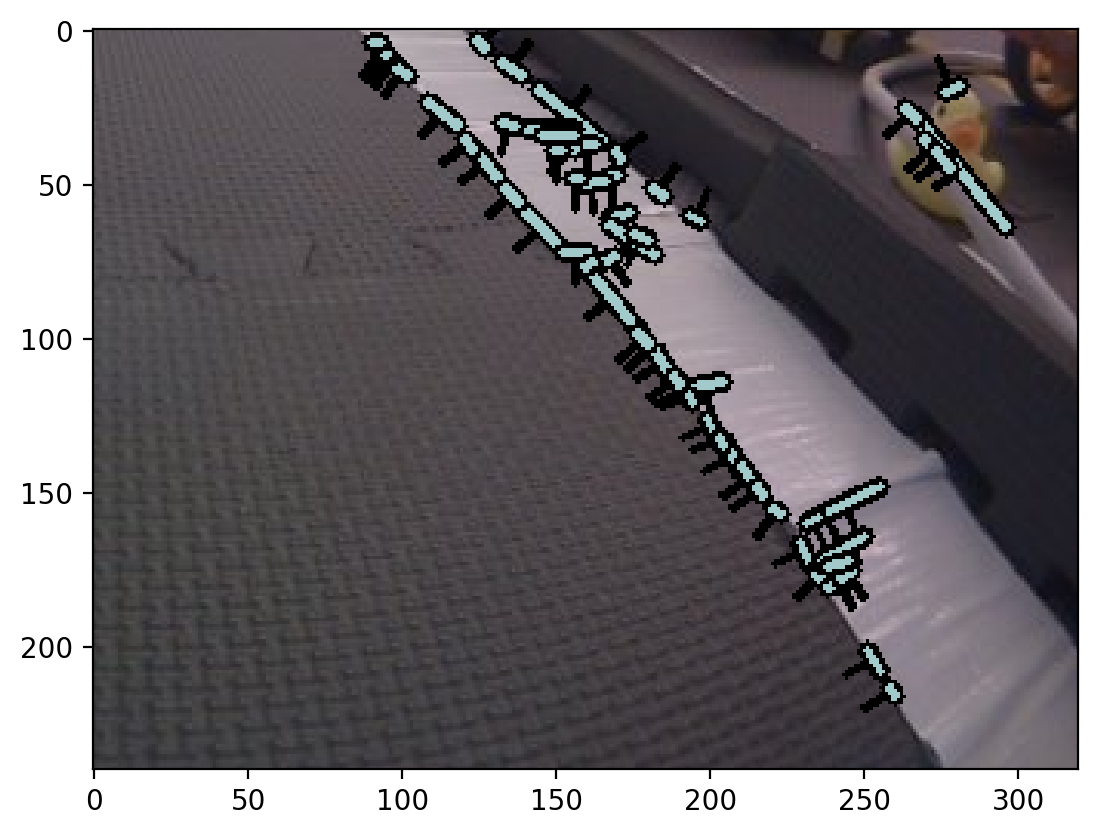

In [6]:
from copy import deepcopy

# define cropping
crop_x_amount = 0.5
crop_y_amount = 0.5

# create new camera parameters
crop_x = int(image_orig.shape[1] * crop_x_amount)
crop_y = int(image_orig.shape[0] * crop_y_amount)
camera_params_orig = deepcopy(camera_properties)
camera_params_cropped = deepcopy(camera_properties)
camera_params_cropped["K"][0][2] -= crop_x
camera_params_cropped["K"][1][2] -= crop_y

# TODO: this should be using the rectified cx, cy instead
camera_params_cropped["P"][0][2] -= crop_x
camera_params_cropped["P"][1][2] -= crop_y

# crop image
image_cropped = image_orig[crop_y:, crop_x:, :]
assert image_cropped.shape == (image_orig.shape[0] - crop_y, image_orig.shape[1] - crop_x, image_orig.shape[2])

# update camera
camera_cropped = CameraModel(**camera_params_cropped)
projector_cropped = GroundProjector(camera_cropped)

# detect segments
color: str = "white"
segments_cropped, image_w_detections_cropped = detect_color(image_cropped, color)

# draw segments
image_w_detections_cropped = cv2.cvtColor(image_w_detections_cropped, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_detections_cropped)

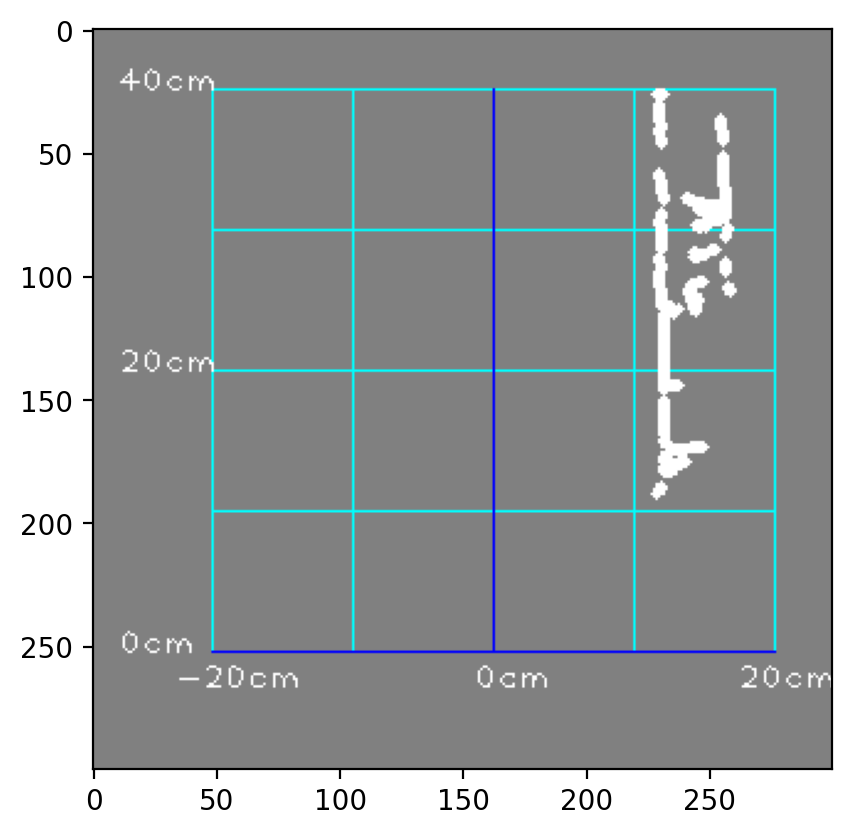

In [7]:
# project segments onto the ground plane
colored_segments_cropped = {
    (255, 255, 255): []
}

for segment in segments_cropped.lines:
    # distorted pixels
    p0: Pixel = Pixel(segment[0], segment[1])
    p1: Pixel = Pixel(segment[2], segment[3])
    #print(p0)
    # distorted pixels to rectified pixels
    p0_rect: Pixel = camera_cropped.rectifier.rectify_pixel(p0)
    p1_rect: Pixel = camera_cropped.rectifier.rectify_pixel(p1)
    #print(p0_rect)
    # rectified pixel to normalized coordinates
    p0_norm: NormalizedImagePoint = camera_cropped.pixel2vector(p0_rect)
    p1_norm: NormalizedImagePoint = camera_cropped.pixel2vector(p1_rect)
    #print(p0_norm)
    # project image point onto the ground plane
    p0_ground: GroundPoint = projector_cropped.vector2ground(p0_norm)
    p1_ground: GroundPoint = projector_cropped.vector2ground(p1_norm)
    # print(p0)
    # add grounded segment to output
    colored_segments_cropped[(255, 255, 255)].append((p0_ground, p1_ground))

image_w_projected_segments_cropped = debug_image(colored_segments_cropped, (300, 300))
image_w_projected_segments_cropped = cv2.cvtColor(image_w_projected_segments_cropped, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_projected_segments_cropped)